In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,21.609390,level_423,level_466,level_66,level_471,level_21,level_293,level_298,level_392,level_120,...,level_311,level_90,level_64,level_363,level_442,level_228,level_103,level_240,level_387,level_216
1,-34.679568,level_255,level_319,level_152,level_102,level_278,level_6,level_280,level_335,level_412,...,level_5,level_275,level_395,level_341,level_284,level_253,level_158,level_414,level_419,level_55
2,-11.430131,level_413,level_347,level_90,level_101,level_115,level_156,level_383,level_140,level_275,...,level_489,level_53,level_404,level_215,level_456,level_493,level_67,level_146,level_324,level_393
3,29.711234,level_60,level_108,level_458,level_183,level_43,level_233,level_98,level_186,level_101,...,level_216,level_463,level_432,level_41,level_308,level_139,level_220,level_136,level_448,level_32
4,-15.009132,level_98,level_140,level_493,level_344,level_2,level_223,level_405,level_111,level_438,...,level_79,level_78,level_291,level_230,level_225,level_9,level_107,level_495,level_284,level_455


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-8.679132,-12.946137,-10.540995,-13.802363,-2.423945,-2.190078,-27.101848,14.417548,-14.502177,-22.410318,...,-10.967147,-2.380420,-10.436120,-13.803981,-2.003209,-4.355741,-0.747413,9.070266,-2.595415,1.803060
1,-9.547589,1.185870,-5.059223,-11.519371,-9.783299,-11.861813,-13.021508,-2.905935,-9.991621,9.410818,...,1.591085,8.329865,-5.047402,-11.882084,7.264065,1.667959,-10.928701,-7.383560,-9.432686,-2.118444
2,-3.888768,8.959155,5.026165,2.543915,12.577426,5.217121,4.682948,-1.366168,0.179817,17.171127,...,10.043307,-2.805734,-3.094489,-5.973781,-4.441704,10.806701,9.085976,-1.319056,-1.361479,11.152599
3,-2.551488,19.544376,16.623793,20.029344,-5.913443,13.356561,7.973948,5.691288,-4.220708,-4.934892,...,-5.519360,0.523508,7.640596,11.276150,3.007670,5.478667,3.651329,2.865009,9.951669,7.248498
4,-11.190103,0.700021,6.473456,5.746871,0.214304,-20.888046,-13.152050,-7.141453,-8.515137,-3.972293,...,-2.847291,-9.850933,-2.008301,-7.821950,4.399075,-14.265884,-1.601099,-7.323682,-6.379215,-1.343901


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-5.409051,-9.534771,-5.165008,-8.025075,-1.767962,-0.914594,-7.807669,4.713296,-11.325538,-14.301553,...,-6.783303,-1.708832,-6.966434,-9.270277,-1.067556,-2.705914,-0.531356,3.622207,-1.198465,1.033777
1,-8.813362,0.886794,-2.835199,-10.507145,-7.201350,-10.046687,-6.575432,-2.096325,-6.857580,4.123817,...,0.650271,2.872083,-3.914992,-4.689325,4.323584,0.846375,-8.963390,-5.109565,-7.899942,-1.377017
2,-3.062155,7.122420,3.298227,2.258247,5.997278,3.605126,3.960861,-0.610069,0.148842,10.793259,...,5.553129,-1.792656,-1.923821,-4.084548,-3.053155,7.541425,4.143451,-1.144251,-0.642274,8.787491
3,-1.898779,12.613384,14.999617,18.263842,-4.578783,12.814313,7.188919,3.285220,-2.726931,-0.751065,...,-2.183322,0.307034,5.524847,5.023735,2.057327,4.542621,2.952050,1.673224,9.103564,6.066340
4,-7.304249,0.455404,4.054707,4.689491,0.131177,-11.722100,-10.791469,-5.111008,-7.170465,-2.934171,...,-1.289193,-3.926041,-0.667166,-5.587118,3.205342,0.000000,-0.943923,-4.648872,-4.826035,-0.982326


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-1.577828,-7.227700,-3.855967,-3.886909e+00,-4.257620,-0.761945,-2.651281,12.682504,-7.761752,-11.772113,...,-4.853190,-0.079950,-7.657039,-7.560701,3.454321,-0.755195,1.257315,10.785771,-2.642234,0.464302
1,-8.002641,1.322067,-3.134132,-9.644490e+00,-6.639595,-9.270213,-5.744349,-4.082217,-5.927746,6.273442,...,3.033130,2.538090,-0.903240,-3.756326,5.267615,13.009085,-6.455530,-2.353809,-8.586595,6.642490
2,-0.243802,7.508896,3.167852,-1.110223e-16,5.862297,7.347908,1.197554,-0.939724,-0.999242,13.469074,...,1.575999,-5.978235,-7.944025,-6.010237,-4.399605,6.958157,3.346978,0.524751,0.000000,9.401659
3,-4.638295,9.099892,11.242872,1.950372e+01,-7.945239,0.000000,5.215806,2.647548,-4.593982,0.000000,...,-4.334630,3.117263,0.000000,3.710264,0.901831,0.384036,1.944163,0.009096,0.000000,7.475121
4,0.000000,1.957648,3.428543,4.586005e+00,2.236838,0.000000,-10.795208,-2.199459,-2.569341,-0.157058,...,1.047682,-2.373316,0.760367,-5.079112,6.617227,0.000000,4.177583,-1.846081,-4.848367,0.000000


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.537538,0.512498,0.173024,0.189492,False
1,var_1_impact_code,0.517274,0.490760,0.143846,0.174671,False
2,var_2_impact_code,0.494306,0.462618,0.106144,0.160621,False
3,var_3_impact_code,0.540377,0.517965,0.196954,0.185956,False
4,var_4_impact_code,0.537606,0.514735,0.176158,0.172490,False
5,var_5_impact_code,0.536109,0.508992,0.169973,0.158436,False
6,var_6_impact_code,0.532761,0.507913,0.154856,0.214377,False
7,var_7_impact_code,0.522554,0.496471,0.166342,0.146731,False
8,var_8_impact_code,0.518686,0.494362,0.136878,0.146182,False
9,var_9_impact_code,0.515479,0.487364,0.133546,0.129562,False


(0.8216353775825459, 4.0110002843803767e-28)


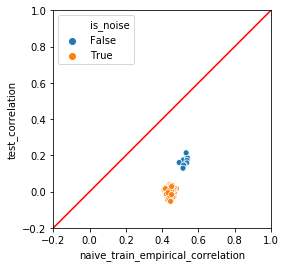

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8144826467457034, 2.7338656166809485e-27)


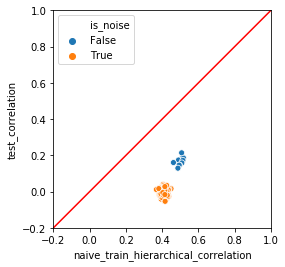

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.7931790631040361, 5.252120745943376e-25)


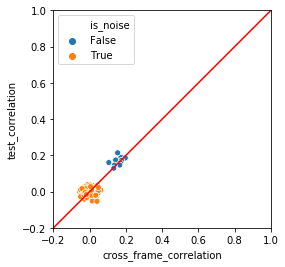

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,noise_95,impact_code,True,True,0.010373,0.600721,110.0,False
106,noise_96_impact_code,noise_96,impact_code,True,True,0.033622,0.089736,110.0,False
107,noise_97_impact_code,noise_97,impact_code,True,True,0.005381,0.786011,110.0,False
108,noise_98_impact_code,noise_98,impact_code,True,True,-0.024979,0.207501,110.0,False
109,noise_99_impact_code,noise_99,impact_code,True,True,-0.018061,0.362136,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_11_impact_code',
 'noise_19_impact_code',
 'noise_81_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,21.609390,-5.276038,0.525848,0.686556,2.688831
1,-11.430131,-0.744079,-3.162960,-2.935260,-5.072990
2,29.711234,7.972856,12.452825,0.039935,0.772492
3,13.826420,-3.398400,-4.491066,-0.955996,-1.191377
4,2.787255,-9.724369,-3.755357,-1.106058,-1.172688


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.148009362822994


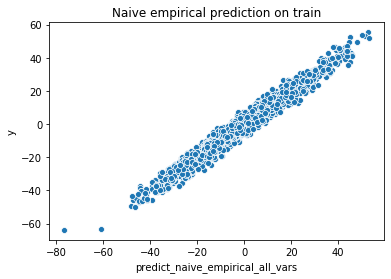

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.642603781688982


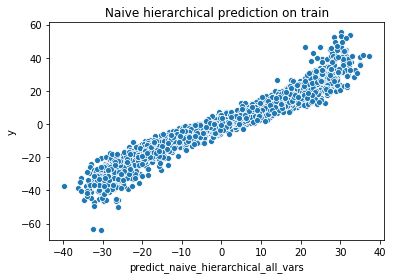

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

14.837879538021449


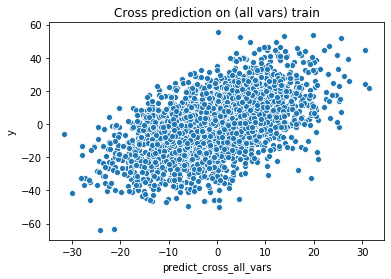

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.21001841587104


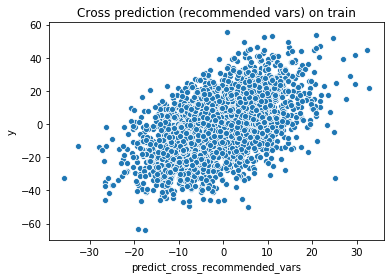

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.945143602822135


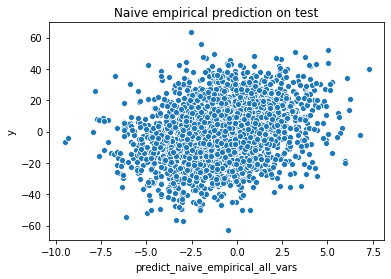

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.56539958000269


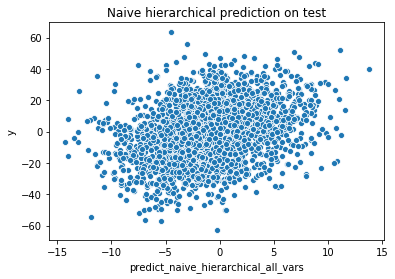

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.9764331468181


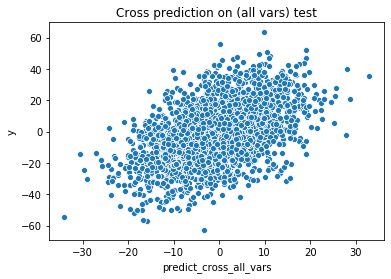

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.658332158893971


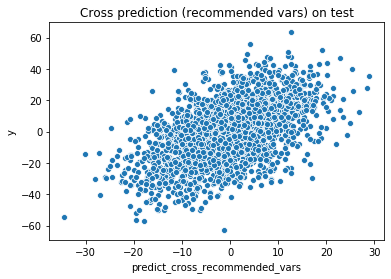

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     680.3
Date:                Fri, 26 Jul 2019   Prob (F-statistic):               0.00
Time:                        18:50:54   Log-Likelihood:                -6537.4
No. Observations:                2548   AIC:                         1.330e+04
Df Residuals:                    2437   BIC:                         1.395e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.7378      0.064    -11.570      0.000      -0.863      -0.613
var_0_impact_code        0.0655      0.008      8.113      0.000       0.050       0.081
var_1_impact_code        0.0676      0.008      8.228      0.000       0.051       0.084
var_2_impact_code        0.0535      0.009      6.286      0.000       0.037       0.070
var_3_impact_code        0.0681      0.008      8.453      0.000       0.052       0.084
var_4_impact_code        0.0765      0.008      9.468      0.000       0.061       0.092
var_5_impact_code        0.0647      0.008      8.024      0.000       0.049       0.081
var_6_impact_code        0.0682      0.008      8.418      0.000       0.052       0.084
var_7_impact_code        0.0727      0.008      8.918      0.000       0.057       0.089
var_8_impact_code        0.0564      0.008      6.819      0.000       0.040       0.073
var_9_impact_code        0.0530      0.008      6.434      0.000       0.037       0.069
noise_0_impact_code      0.0481      0.009      5.254      0.000       0.030       0.066
noise_1_impact_code      0.0403      0.009      4.341      0.000       0.022       0.059
noise_2_impact_code      0.0305      0.009      3.291      0.001       0.012       0.049
noise_3_impact_code      0.0343      0.009      3.733      0.000       0.016       0.052
noise_4_impact_code      0.0517      0.009      5.562      0.000       0.033       0.070
noise_5_impact_code      0.0409      0.010      4.278      0.000       0.022       0.060
noise_6_impact_code      0.0562      0.009      6.100      0.000       0.038       0.074
noise_7_impact_code      0.0352      0.009      3.849      0.000       0.017       0.053
noise_8_impact_code      0.0406      0.010      4.257      0.000       0.022       0.059
noise_9_impact_code      0.0282      0.009      3.070      0.002       0.010       0.046
noise_10_impact_code     0.0237      0.009      2.542      0.011       0.005       0.042
noise_11_impact_code     0.0379      0.009      4.367      0.000       0.021       0.055
noise_12_impact_code     0.0485      0.009      5.222      0.000       0.030       0.067
noise_13_impact_code     0.0450      0.009      4.762      0.000       0.026       0.064
noise_14_impact_code     0.0399      0.009      4.247      0.000       0.021       0.058
noise_15_impact_code     0.0477      0.009      5.113      0.000       0.029       0.066
noise_16_impact_code     0.0401      0.009      4.412      0.000       0.022       0.058
noise_17_impact_code     0.0344      0.009      3.709      0.000       0.016       0.053
noise_18_impact_code     0.0413      0.009      4.367      0.000       0.023       0.060
noise_19_impact_code     0.0531      0.009      6.048      0.000       0.036       0.070
noise_20_impact_code     0.0514      0.009      5.568    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.968462555157565

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.054959350522135186

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     9.466
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          1.97e-121
Time:                        18:50:54   Log-Likelihood:                -10488.
No. Observations:                2548   AIC:                         2.120e+04
Df Residuals:                    2437   BIC:                         2.185e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.6033      0.306     -1.973      0.049      -1.203      -0.004
var_0_impact_code        0.4912      0.047     10.458      0.000       0.399       0.583
var_1_impact_code        0.4072      0.048      8.445      0.000       0.313       0.502
var_2_impact_code        0.2776      0.052      5.369      0.000       0.176       0.379
var_3_impact_code        0.5005      0.046     10.832      0.000       0.410       0.591
var_4_impact_code        0.5155      0.047     10.962      0.000       0.423       0.608
var_5_impact_code        0.4462      0.045      9.942      0.000       0.358       0.534
var_6_impact_code        0.4556      0.049      9.368      0.000       0.360       0.551
var_7_impact_code        0.4614      0.046     10.060      0.000       0.371       0.551
var_8_impact_code        0.3792      0.049      7.789      0.000       0.284       0.475
var_9_impact_code        0.3201      0.048      6.685      0.000       0.226       0.414
noise_0_impact_code      0.0464      0.061      0.759      0.448      -0.073       0.166
noise_1_impact_code     -0.0058      0.062     -0.093      0.926      -0.128       0.116
noise_2_impact_code     -0.0414      0.058     -0.711      0.477      -0.156       0.073
noise_3_impact_code     -0.0308      0.057     -0.542      0.588      -0.142       0.081
noise_4_impact_code      0.0780      0.059      1.330      0.184      -0.037       0.193
noise_5_impact_code     -0.0494      0.063     -0.790      0.430      -0.172       0.073
noise_6_impact_code      0.1061      0.058      1.825      0.068      -0.008       0.220
noise_7_impact_code      0.0147      0.056      0.262      0.793      -0.095       0.124
noise_8_impact_code     -0.0473      0.061     -0.780      0.436      -0.166       0.072
noise_9_impact_code      0.0491      0.059      0.839      0.402      -0.066       0.164
noise_10_impact_code     0.0237      0.059      0.400      0.689      -0.092       0.140
noise_11_impact_code     0.1177      0.054      2.172      0.030       0.011       0.224
noise_12_impact_code     0.0657      0.059      1.120      0.263      -0.049       0.181
noise_13_impact_code     0.0104      0.061      0.169      0.866      -0.110       0.131
noise_14_impact_code    -0.0246      0.060     -0.413      0.680      -0.141       0.092
noise_15_impact_code    -0.0717      0.060     -1.192      0.234      -0.190       0.046
noise_16_impact_code     0.0480      0.056      0.852      0.394      -0.063       0.159
noise_17_impact_code    -0.0283      0.055     -0.512      0.609      -0.136       0.080
noise_18_impact_code    -0.0556      0.060     -0.921      0.357      -0.174       0.063
noise_19_impact_code     0.0857      0.055      1.571      0.116      -0.021       0.193
noise_20_impact_code     0.0754      0.058      1.298    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.29935479356295913

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.2509405864802372

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     69.84
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          8.73e-158
Time:                        18:50:54   Log-Likelihood:                -10551.
No. Observations:                2548   AIC:                         2.113e+04
Df Residuals:                    2534   BIC:                         2.121e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.6580      0.303     -2.174      0.030      -1.252      -0.064
var_0_impact_code        0.5021      0.046     10.841      0.000       0.411       0.593
var_1_impact_code        0.4137      0.048      8.709      0.000       0.321       0.507
var_2_impact_code        0.3071      0.051      6.024      0.000       0.207       0.407
var_3_impact_code        0.5248      0.046     11.506      0.000       0.435       0.614
var_4_impact_code        0.5113      0.046     11.040      0.000       0.421       0.602
var_5_impact_code        0.4550      0.044     10.267      0.000       0.368       0.542
var_6_impact_code        0.4714      0.048      9.874      0.000       0.378       0.565
var_7_impact_code        0.4736      0.045     10.425      0.000       0.385       0.563
var_8_impact_code        0.3941      0.048      8.260      0.000       0.301       0.488
var_9_impact_code        0.3393      0.047      7.183      0.000       0.247       0.432
noise_11_impact_code     0.1268      0.054      2.365      0.018       0.022       0.232
noise_19_impact_code     0.0973      0.054      1.804      0.071      -0.008       0.203
noise_81_impact_code     0.1240      0.055      2.264      0.024       0.017       0.231
==============================================================================
Omnibus:                        3.832   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                3.886
Skew:                          -0.089   Prob(JB):                        0.143
Kurtosis:                       2.931   Cond. No.                         6.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.26376924929240864

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.28047213688877426